In [1]:
import sys
sys.path.append('../../../self_learning_with_venn_abers_predictors/')

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.autograd import Variable
from collections import OrderedDict
import tensorflow as tf

from python_code.neural_net import SimpleNeuralNet, SimpleNeuralNetCredal
from python_code.utils import MyDataset, plot_decision_boundary

2023-01-27 13:35:35.619514: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv("../../data/SynthCross_n1000_p2.csv")
df["z"] = df["z"].apply(lambda x: 1 if x=="A" else 0)

In [3]:
df["z"].value_counts()

0    510
1    490
Name: z, dtype: int64

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(df[["X1", "X2"]], df["z"], train_size=0.8)
X_train, X_calib, Y_train, Y_calib = train_test_split(X_train, Y_train, train_size=0.975)
trainset = pd.DataFrame(X_train, columns=["X1", "X2"])
trainset["z"] = Y_train
trainset.iloc[80:, trainset.columns.get_loc("z")] = np.NaN 
known_train = trainset.iloc[0:80]
unknow_train = trainset.iloc[80:]
known_train.shape, unknow_train.shape, X_calib.shape, X_test.shape

((80, 3), (700, 3), (20, 2), (200, 2))

# Self Learning strategy 1

In [5]:
class SelfLearning():
    def __init__(
        self,
        known_x_train,
        known_y_train,
        unknown_x_train,
        model_convergence_epochs 
    ):
        self.model_convergence_epochs = model_convergence_epochs
        self.model = SimpleNeuralNet(clipping_value=0.000001, n_input_units=2, n_hidden_units=3)
        self.known_x_train = known_x_train
        self.known_y_train = known_y_train
        self.unknown_x_train = unknown_x_train
        
        self.model.fit(self.known_x_train, self.known_y_train, epochs=self.model_convergence_epochs, learning_rate=0.1)
        self.accuracies = []
    
    def learning(self, validation_x, validation_y, batch_adding=5):
        while len(self.unknown_x_train) >= batch_adding:
            self.unknown_x_train["y"] = self.model.predict_probas(self.unknown_x_train.to_numpy()).detach().numpy()
            self.unknown_x_train.sort_values("y", ascending=False, inplace=True)
            self.unknown_x_train["y"] = self.unknown_x_train["y"].apply(lambda x: 1 if x>0.5 else 0)
            self.known_x_train = pd.concat(
                [
                    self.known_x_train,
                    self.unknown_x_train.iloc[0:batch_adding][["X1", "X2"]],
                    self.unknown_x_train.iloc[-batch_adding:][["X1", "X2"]]
                ]
            )
            self.known_y_train = pd.concat(
                [
                    self.known_y_train,
                    self.unknown_x_train.iloc[0:batch_adding]["y"],
                    self.unknown_x_train.iloc[-batch_adding:]["y"]
                ]
            )
            self.unknown_x_train = self.unknown_x_train.iloc[batch_adding:-batch_adding][["X1", "X2"]]
            predictions = self.model.predict_probas(validation_x.to_numpy()).reshape(-1).detach().numpy().round()
            self.accuracies.append(accuracy_score(validation_y, predictions))
            self.model.fit(self.known_x_train, self.known_y_train, epochs=self.model_convergence_epochs, learning_rate=0.1, verbose=False)

Epoch 1/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6788 - accuracy: 0.5625
Epoch 2/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6507 - accuracy: 0.5875
Epoch 3/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6366 - accuracy: 0.6250
Epoch 4/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6271 - accuracy: 0.6500
Epoch 5/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6194 - accuracy: 0.6500
Epoch 6/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6129 - accuracy: 0.6500
Epoch 7/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6070 - accuracy: 0.6375
Epoch 8/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6015 - accuracy: 0.6500
Epoch 9/10
8/8 [==============================] - 0s 3ms/step - loss: 0.5962 - accuracy: 0.6375
Epoch 10/10
8/8 [==============================] - 0s 3ms/step - loss: 0.5909 - accuracy: 0.6500



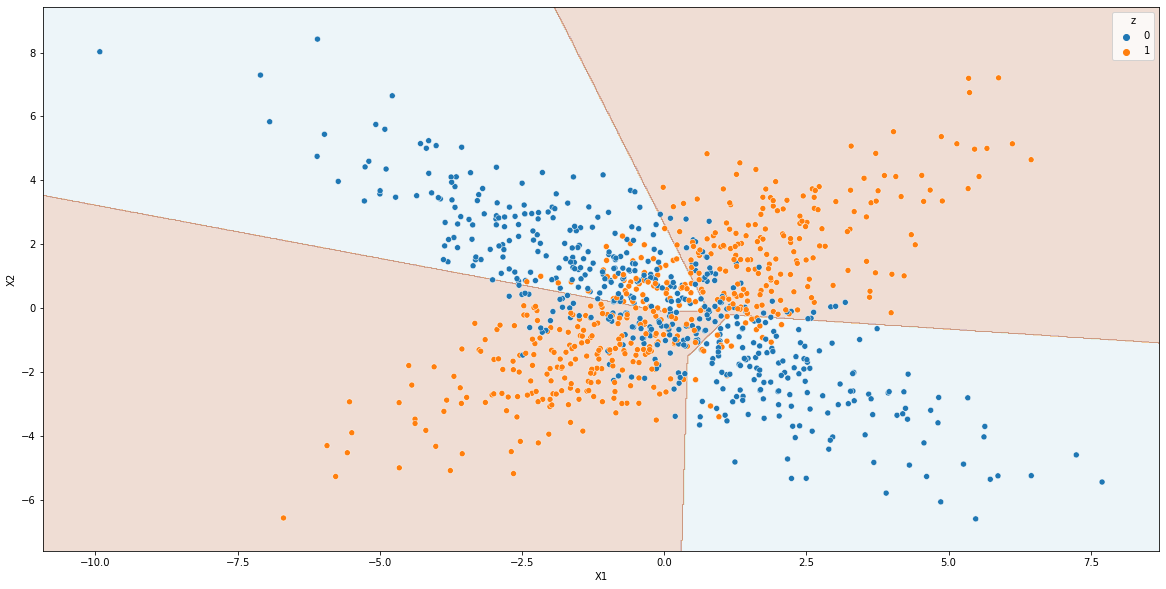

In [6]:
test = SelfLearning(
    known_x_train=known_train[["X1", "X2"]],
    known_y_train=known_train["z"],
    unknown_x_train=unknow_train[["X1", "X2"]],
    model_convergence_epochs=10
)
test.learning(validation_x=X_test, validation_y=Y_test)
fig, ax = plot_decision_boundary(dataset=df[["X1", "X2"]], labels=np.array([0, 1]), model=test.model)
sns.scatterplot(data=df, x="X1", y="X2", hue="z", ax=ax)
plt.show()

In [7]:
accuracy_score(test.model.predict_probas(X_test.to_numpy()).reshape(-1).detach().numpy().round(), Y_test)

0.78

# Self Learning Strategy 2

In [8]:
class SelfLearningWithSoft():
    def __init__(
        self,
        known_x_train,
        known_y_train,
        unknown_x_train,
        model_convergence_epochs 
    ):
        self.model_convergence_epochs = model_convergence_epochs
        self.model = SimpleNeuralNet(clipping_value=0.000001, n_input_units=2, n_hidden_units=3)
        self.known_x_train = known_x_train
        self.known_y_train = known_y_train
        self.unknown_x_train = unknown_x_train
        self.length_known = len(self.known_y_train)
        
        self.model.fit(self.known_x_train, self.known_y_train, epochs=self.model_convergence_epochs, learning_rate=0.001)
        self.accuracies = []
    
    def learning(self, validation_x, validation_y, n_epochs=10):
        for epochs in range(n_epochs):
            # print(self.known_y_train)
            # print()
            self.known_y_train = self.known_y_train.apply(lambda x: x-0.001 if x==1 else x+0.001 if x==0 else x)
            # print(self.known_y_train)
            self.unknown_x_train["y"] = self.model.predict_probas(self.unknown_x_train.to_numpy()).detach().numpy()
            # import pdb; pdb.set_trace()
            self.known_x_train = pd.concat(
                [
                    self.known_x_train,
                    self.unknown_x_train[["X1", "X2"]],
                ]
            ).drop_duplicates()
            if epochs == 0:
                self.known_y_train = pd.concat(
                    [
                        self.known_y_train,
                        self.unknown_x_train["y"],
                    ]
                )
            else:
                self.known_y_train[self.length_known:] = self.unknown_x_train["y"]
            self.unknown_x_train = self.unknown_x_train[["X1", "X2"]]
            predictions = self.model.predict_probas(validation_x.to_numpy()).reshape(-1).detach().numpy().round()
            self.accuracies.append(accuracy_score(validation_y, predictions))
            print(f"Accuracy epochs {epochs}: {accuracy_score(validation_y, predictions)}")
            self.model.fit(
                self.known_x_train, self.known_y_train, epochs=self.model_convergence_epochs, learning_rate=0.1, verbose=False, soft=True
            )

Epoch 1/10
8/8 [==============================] - 0s 3ms/step - loss: 0.7127 - accuracy: 0.4875
Epoch 2/10
8/8 [==============================] - 0s 2ms/step - loss: 0.7122 - accuracy: 0.4875
Epoch 3/10
8/8 [==============================] - 0s 2ms/step - loss: 0.7117 - accuracy: 0.5000
Epoch 4/10
8/8 [==============================] - 0s 3ms/step - loss: 0.7112 - accuracy: 0.5000
Epoch 5/10
8/8 [==============================] - 0s 2ms/step - loss: 0.7108 - accuracy: 0.5000
Epoch 6/10
8/8 [==============================] - 0s 2ms/step - loss: 0.7103 - accuracy: 0.5125
Epoch 7/10
8/8 [==============================] - 0s 2ms/step - loss: 0.7098 - accuracy: 0.5125
Epoch 8/10
8/8 [==============================] - 0s 3ms/step - loss: 0.7094 - accuracy: 0.5125
Epoch 9/10
8/8 [==============================] - 0s 2ms/step - loss: 0.7089 - accuracy: 0.5125
Epoch 10/10
8/8 [==============================] - 0s 4ms/step - loss: 0.7084 - accuracy: 0.5125
Accuracy epochs 0: 0.58
Accuracy epochs

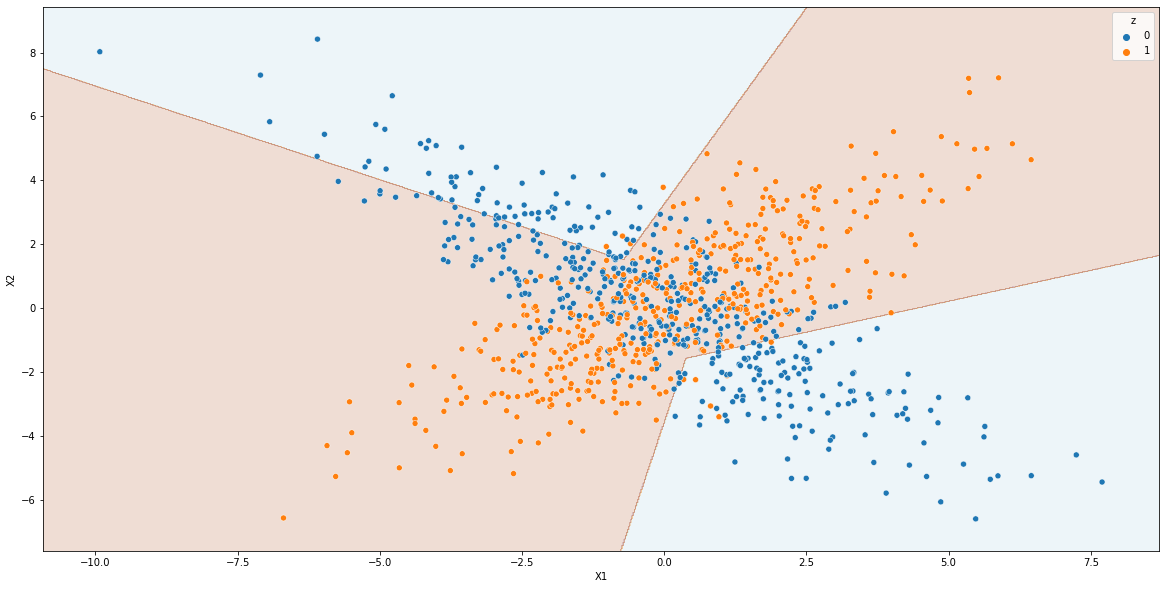

In [9]:
test = SelfLearningWithSoft(
    known_x_train=known_train[["X1", "X2"]],
    known_y_train=known_train["z"],
    unknown_x_train=unknow_train[["X1", "X2"]],
    model_convergence_epochs=10
)
test.learning(validation_x=X_test, validation_y=Y_test, n_epochs=10)
fig, ax = plot_decision_boundary(dataset=df[["X1", "X2"]], labels=np.array([0, 1]), model=test.model)
sns.scatterplot(data=df, x="X1", y="X2", hue="z", ax=ax)
plt.show()

In [10]:
accuracy_score(test.model.predict_probas(X_test.to_numpy()).reshape(-1).detach().numpy().round(), Y_test)

0.72

# Self Learning Strategy 3

In [11]:
class SelfLearningUsingVennAbers():
    def __init__(
        self,
        known_x_train,
        known_y_train,
        unknown_x_train,
        calib_x_train, 
        calib_y_train,
        model_convergence_epochs
    ):
        self.model_convergence_epochs = model_convergence_epochs
        self.model = SimpleNeuralNetCredal(clipping_value=0.1, n_input_units=2, n_hidden_units=3)
        self.known_x_train = known_x_train
        self.known_y_train = known_y_train
        self.unknown_x_train = unknown_x_train
        self.calib_x_train = calib_x_train
        self.calib_y_train = calib_y_train
        self.length_known = len(self.known_y_train)
        
        self.model.fit(self.known_x_train, self.known_y_train, epochs=self.model_convergence_epochs, learning_rate=0.2)
        self.accuracies = []
        fig, ax = plot_decision_boundary(dataset=df[["X1", "X2"]], labels=np.array([0, 1]), model=self.model)
        sns.scatterplot(data=df, x="X1", y="X2", hue="z", ax=ax)
        plt.show()
    
    def learning(self, validation_x, validation_y, n_epochs=10):
        self.known_y_train = self.known_y_train.apply(
            lambda x: np.stack(
                [x+0.001, x+0.001] if x == 0 else [x-0.001, x-0.001] if x ==1 else x,
                axis=-1
        ).astype(np.float32))
        for epochs in range(n_epochs):
            self.unknown_x_train["interval"] =  self.unknown_x_train.apply(
                lambda x: venn_abers_pytorch(
                    self.model,
                    torch.from_numpy(self.calib_x_train[["X1", "X2"]].values.astype(np.float32)),
                    torch.from_numpy(x[["X1", "X2"]].values.reshape(1, -1).astype(np.float32)),
                    self.calib_y_train)
                ,
                axis=1
            )
            self.known_x_train = pd.concat(
                [
                    self.known_x_train,
                    self.unknown_x_train[["X1", "X2"]],
                ]
            ).drop_duplicates()
            if epochs == 0:
                self.known_y_train = pd.concat(
                    [
                        self.known_y_train,
                        self.unknown_x_train["interval"],
                    ]
                )
            else:
                self.known_y_train[self.length_known:] = self.unknown_x_train["interval"]
            
            self.unknown_x_train = self.unknown_x_train[["X1", "X2"]]
            predictions = self.model.predict_probas(validation_x.to_numpy()).reshape(-1).detach().numpy().round()
            self.accuracies.append(accuracy_score(validation_y, predictions))
            if (epochs+1) % 5 == 0 or epochs==0:
                print(f"Accuracy epochs {epochs+1}: {accuracy_score(validation_y, predictions)}")
                fig, ax = plot_decision_boundary(dataset=df[["X1", "X2"]], labels=np.array([0, 1]), model=self.model)
                sns.scatterplot(data=df, x="X1", y="X2", hue="z", ax=ax)
                plt.show()
            self.model.fit(
                self.known_x_train,
                self.known_y_train,
                epochs=self.model_convergence_epochs,
                learning_rate=0.2,
                verbose=False,
                credal=True
            )
            
    
    def predict_probas(self, x_test):
        probs = self.model.predict_probas(x_test, from_numpy=True, as_numpy=True)
        return probs
    
    def predict_probas_interval(self, x_test):
        returns = x_test.copy()
        returns["interval"] = returns.apply(
                lambda x: venn_abers_pytorch(
                    self.model,
                    torch.from_numpy(self.calib_x_train[["X1", "X2"]].values.astype(np.float32)),
                    torch.from_numpy(x[["X1", "X2"]].values.reshape(1, -1).astype(np.float32)),
                    self.calib_y_train)
                ,
                axis=1
            )
        return returns

Epoch 1/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6674 - accuracy: 0.6000
Epoch 2/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6521 - accuracy: 0.6250
Epoch 3/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6390 - accuracy: 0.6250
Epoch 4/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6237 - accuracy: 0.6375
Epoch 5/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6074 - accuracy: 0.6500
Epoch 6/10
8/8 [==============================] - 0s 3ms/step - loss: 0.5895 - accuracy: 0.6750
Epoch 7/10
8/8 [==============================] - 0s 2ms/step - loss: 0.5723 - accuracy: 0.6750
Epoch 8/10
8/8 [==============================] - 0s 2ms/step - loss: 0.5560 - accuracy: 0.6750
Epoch 9/10
8/8 [==============================] - 0s 3ms/step - loss: 0.5383 - accuracy: 0.6750
Epoch 10/10
8/8 [==============================] - 0s 3ms/step - loss: 0.5194 - accuracy: 0.6625



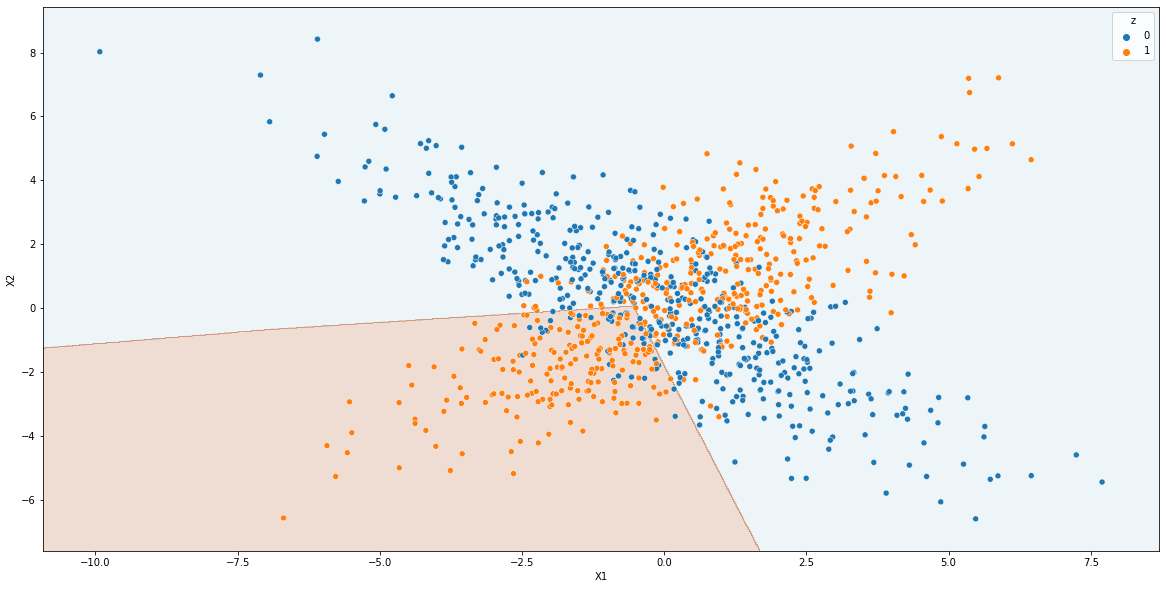

In [12]:
test = SelfLearningUsingVennAbers(
    known_x_train=known_train[["X1", "X2"]],
    known_y_train=known_train["z"],
    unknown_x_train=unknow_train[["X1", "X2"]],
    calib_x_train=X_calib[["X1", "X2"]],
    calib_y_train=Y_calib,
    model_convergence_epochs=10
)

Accuracy epochs 1: 0.66



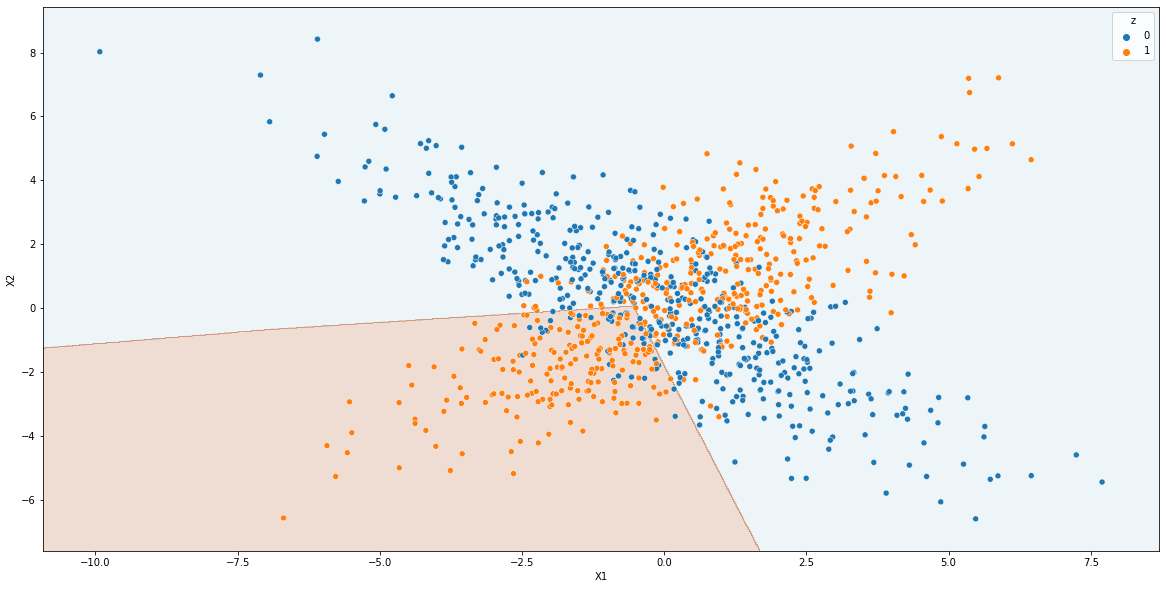

Accuracy epochs 5: 0.78



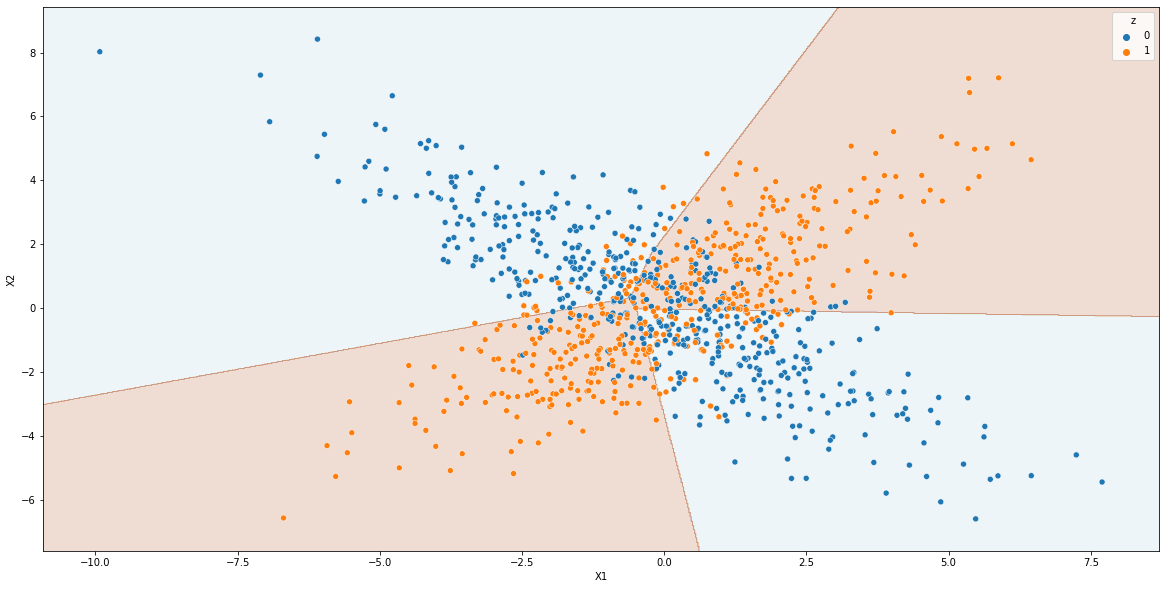

Accuracy epochs 10: 0.785



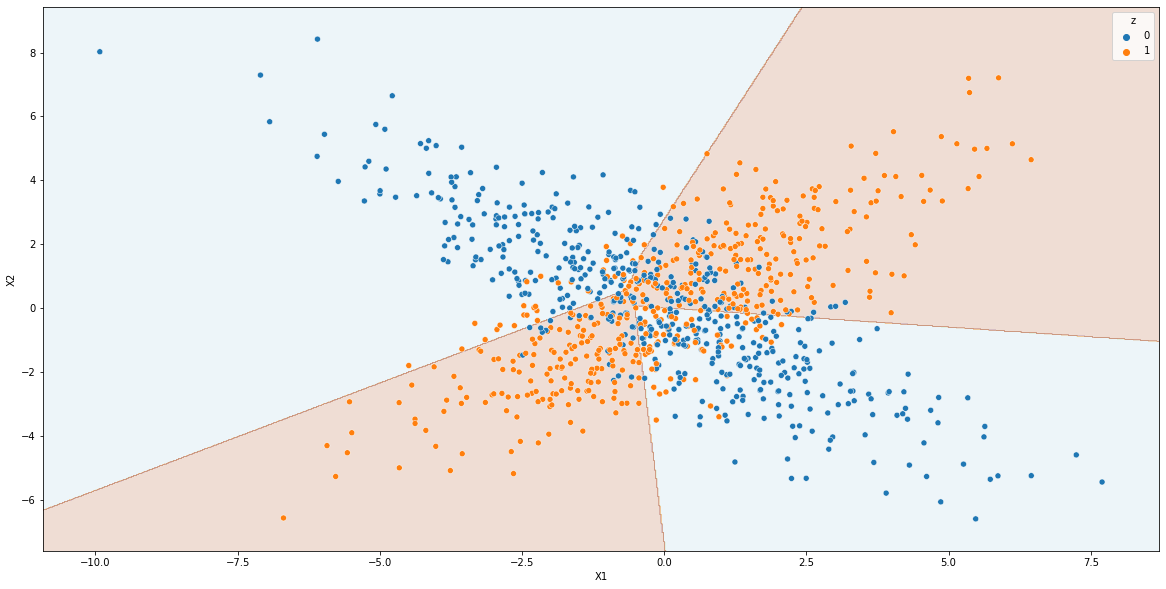

In [13]:
test.learning(validation_x=X_test, validation_y=Y_test, n_epochs=10)

In [14]:
accuracy_score(test.model.predict_probas(X_test.to_numpy()).reshape(-1).detach().numpy().round(), Y_test)

0.79

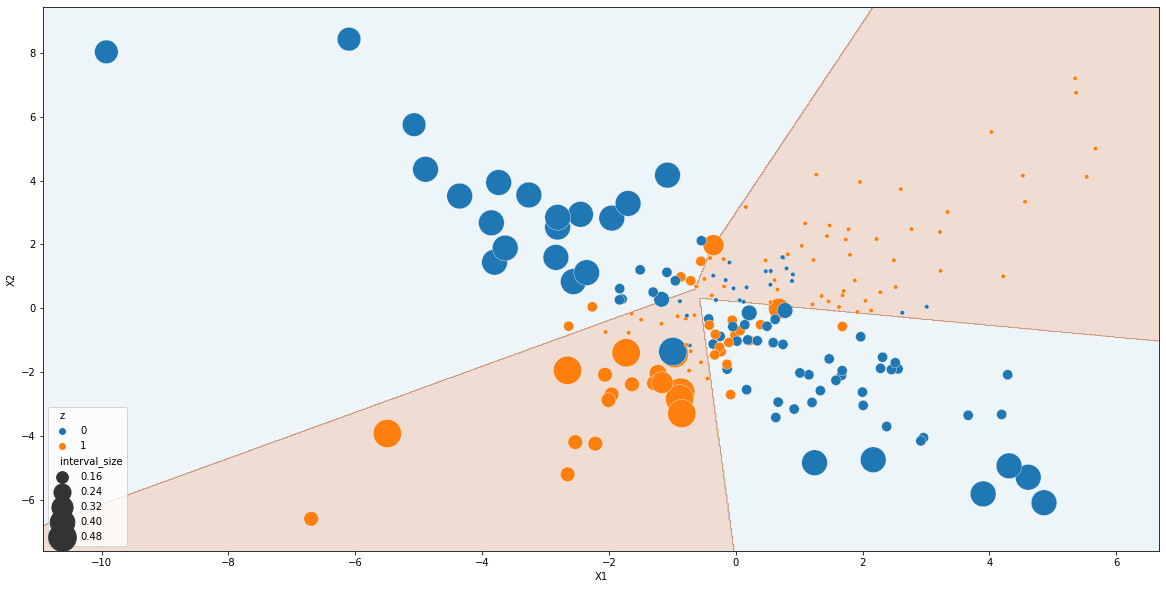

In [15]:
visu = test.predict_probas_interval(X_test)
visu["interval_size"] = visu["interval"].apply(lambda x: x[1] - x[0])
fig, ax = plot_decision_boundary(dataset=X_test, labels=np.array([0, 1]), model=test.model)
sns.scatterplot(data=X_test, x="X1", y="X2", hue=Y_test, ax=ax, size=visu["interval_size"], sizes=(20, 800))
plt.show()

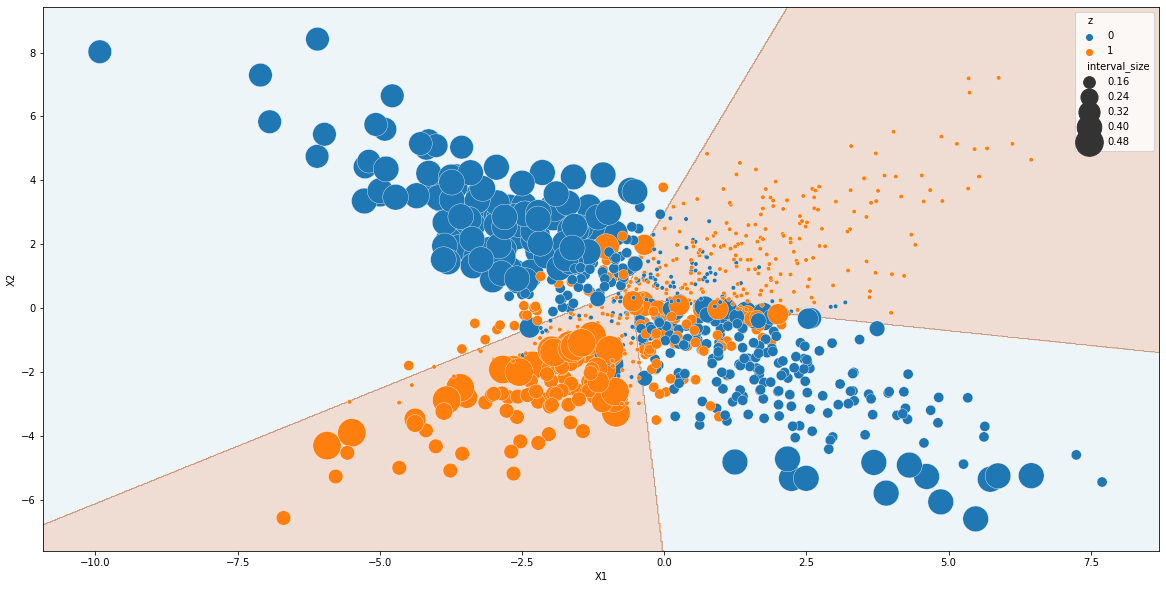

In [16]:
dff = pd.concat([df,pd.concat([X_calib, Y_calib], axis=1)]).drop_duplicates(keep=False)
new_df = test.predict_probas_interval(x_test=dff[["X1", "X2"]])
new_df["interval_size"] = new_df["interval"].apply(lambda x: x[1] - x[0])
fig, ax = plot_decision_boundary(dataset=new_df, labels=np.array([0, 1]), model=test.model)
sns.scatterplot(data=new_df, x="X1", y="X2", hue=df["z"], ax=ax, size="interval_size", sizes=(20, 800))
plt.show()

In [21]:
visu["y"] = Y_test
visu["predicted"] = test.model.predict_probas(visu[["X1", "X2"]].to_numpy()).detach().numpy()
visu["label_predicted"] = test.model.predict_probas(visu[["X1", "X2"]].to_numpy()).detach().numpy().round()
visu.to_csv("observation.csv")

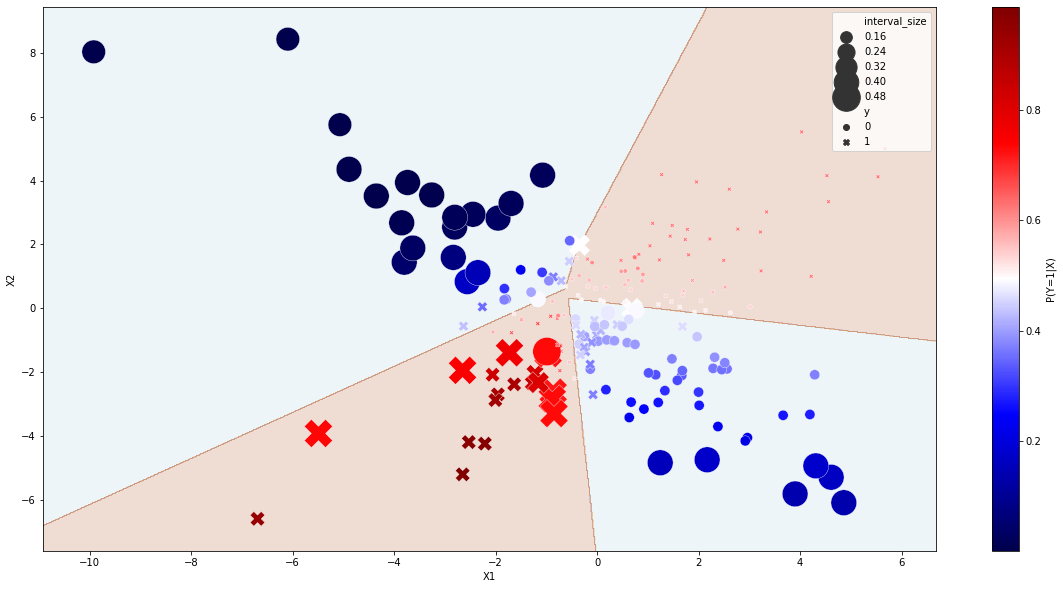

In [34]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
fig, ax = plot_decision_boundary(dataset=X_test, labels=np.array([0, 1]), model=test.model)
ax = sns.scatterplot(
    data=visu,
    x="X1",
    y="X2",
    c=visu["predicted"],
    ax=ax,
    size="interval_size",
    sizes=(20, 800),
    style="y",
    cmap = 'seismic'
)
norm = plt.Normalize(visu['predicted'].min(), visu['predicted'].max())
sm = plt.cm.ScalarMappable(cmap="seismic", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('P(Y=1|X)')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1, 1))
plt.show()

In [23]:
new_df["predicted"] = test.model.predict_probas(new_df[["X1", "X2"]].to_numpy()).detach().numpy()
new_df["label_predicted"] = test.model.predict_probas(new_df[["X1", "X2"]].to_numpy()).detach().numpy().round()
new_df["y"] = dff["z"]

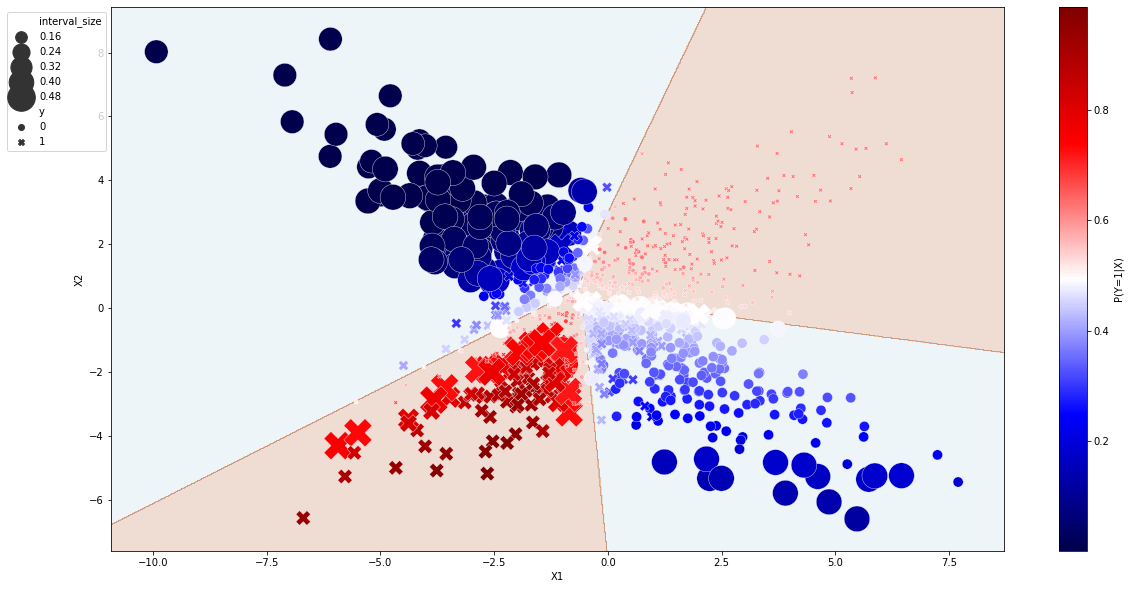

In [33]:
fig, ax = plot_decision_boundary(dataset=new_df, labels=np.array([0, 1]), model=test.model)
ax = sns.scatterplot(
    data=new_df,
    x="X1",
    y="X2",
    c=new_df["predicted"],
    ax=ax,
    size="interval_size",
    sizes=(20, 800),
    style="y",
    cmap = 'seismic'
)
norm = plt.Normalize(new_df['predicted'].min(), new_df['predicted'].max())
sm = plt.cm.ScalarMappable(cmap="seismic", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('P(Y=1|X)')
sns.move_legend(ax, "upper right", bbox_to_anchor=(0, 1))
plt.show()